In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import json
import pprint
import seaborn as sns
import numpy as np
import random
from time import time
import pickle

In [2]:
from pymongo import MongoClient
from stop_words import get_stop_words
from nltk.stem import WordNetLemmatizer
import gensim
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [3]:
def SaveDict(filename, mode, root):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, mode) as f:
        f.write(pprint.pformat(root))

def LoadDict(filename):
    if filename[-4:]!=".txt":
        filename+=".txt"
    with open(filename, "r") as f:
        return eval(f.read())

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [5]:
client = MongoClient()
db = client.twitter

In [ ]:
texts = []
for article in db.articles.find():
    doc = article['text']

    doc = doc.replace("\n"," ")
    doc = doc.replace("\'","")

    doc = gensim.utils.simple_preprocess(doc)

    wordnet_lemmatizer = WordNetLemmatizer()
    doc = [wordnet_lemmatizer.lemmatize(word) for word in doc]
    doc = [wordnet_lemmatizer.lemmatize(word,pos='v') for word in doc]

    en_stop = get_stop_words('en')
    letters = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]
    other = ["wa","ha","one","two","id","re","http","com","mr","image","photo","caption","don","sen","pic","co",
             "source","watch","play","duration","video","momentjs","getty","images","newsletter", "story", "go", "like", "say",
             "will", "just", "today", "can", "year", "make", "view", "read"]
    doc = [word for word in doc if not word in (en_stop+letters+other)]
    db.articles.update_one({"_id": article["_id"]}, {"$set": {"clean_text": doc}})
    texts.append(doc)

In [ ]:
random.seed(42)
train_set = random.sample(list(range(0,len(texts))),len(texts)-1000)
test_set = [x for x in list(range(0,len(texts))) if x not in train_set]

train_texts = [texts[i] for i in train_set]
test_texts = [texts[i] for i in test_set]

pickle.dump([train_set,test_set,train_texts,test_texts],open('pub_articles_train_test_sets.pkl','wb'))

In [ ]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

dictionary = corpora.Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]

ldamodels_bow = {}
for i in topicnums:
    random.seed(42)
    %time ldamodels_bow[i] = models.ldamodel.LdaModel(corpus,num_topics=i,id2word=dictionary)
    ldamodels_bow[i].save('ldamodels_bow_'+str(i)+'.lda')

In [5]:
# http://radimrehurek.com/topic_modeling_tutorial/2%20-%20Topic%20Modeling.html
def intra_inter(lda_model, dictionary, test_docs, num_pairs=10000):
    
    # Split each test document into two halves and compute topics for each half
    part1 = [lda_model[dictionary.doc2bow(tokens[:int(len(tokens)/2)])] for tokens in test_docs]
    part2 = [lda_model[dictionary.doc2bow(tokens[int(len(tokens)/2):])] for tokens in test_docs]   
    
    # Compute topic distribution similarities using cosine similarity
    
    #print("Average cosine similarity between corresponding parts (higher is better):")
    corresp_parts = np.mean([gensim.matutils.cossim(p1, p2) for p1, p2 in zip(part1, part2)])

    #print("Average cosine similarity between 10,000 random parts (lower is better):")    
    random.seed(42)
    random_pairs = np.random.randint(0, len(test_docs), size=(num_pairs, 2))
    random_parts = np.mean([gensim.matutils.cossim(part1[i[0]], part2[i[1]]) for i in random_pairs])
    
    return corresp_parts, random_parts

In [ ]:
ldamodels_eval = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('ldamodels_bow_'+str(i)+'.lda')
    ldamodels_eval[i] = intra_inter(lda_model, dictionary, test_texts)
    
pickle.dump(ldamodels_eval,open('pub_ldamodels_eval.pkl','wb'))

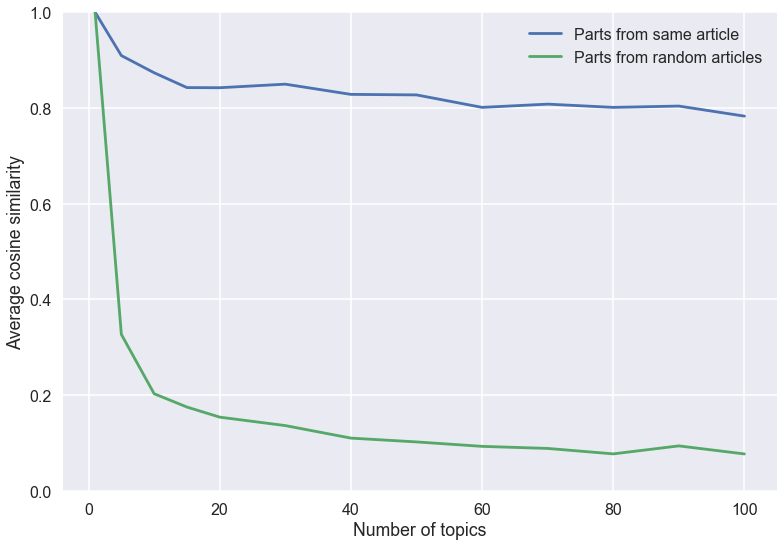

In [6]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

ldamodels_eval = pickle.load(open('pub_ldamodels_eval.pkl','rb'))
corresp_parts = [ldamodels_eval[i][0] for i in topicnums]
random_parts = [ldamodels_eval[i][1] for i in topicnums]
sns.set_context("poster")
with sns.axes_style("darkgrid"):
    x = topicnums
    y1 = corresp_parts
    y2 = random_parts
    plt.plot(x,y1,label='Parts from same article')
    plt.plot(x,y2,label='Parts from random articles')
    plt.ylim([0.0,1.0])
    plt.xlabel('Number of topics')
    plt.ylabel('Average cosine similarity')    
    plt.legend()    
    plt.show()

In [7]:
topicnums = [1,5,10,15,20,30,40,50,60,70,80,90,100]

lda_topics = {}
for i in topicnums:
    lda_model = models.ldamodel.LdaModel.load('ldamodels_bow_'+str(i)+'.lda')
    lda_topics_string = lda_model.show_topics(i)
    lda_topics[i] = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics_string]

pickle.dump(lda_topics,open('pub_lda_topics.pkl','wb'))

In [8]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return float(len(intersection))/float(len(union))

In [9]:
lda_stability = {}
for i in range(0,len(topicnums)-1):
    jacc_sims = []
    for t1,topic1 in enumerate(lda_topics[topicnums[i]]):
        sims = []
        for t2,topic2 in enumerate(lda_topics[topicnums[i+1]]):
            sims.append(jaccard_similarity(topic1,topic2))    
        jacc_sims.append(sims)    
    lda_stability[topicnums[i]] = jacc_sims
    
pickle.dump(lda_stability,open('pub_lda_stability.pkl','wb'))

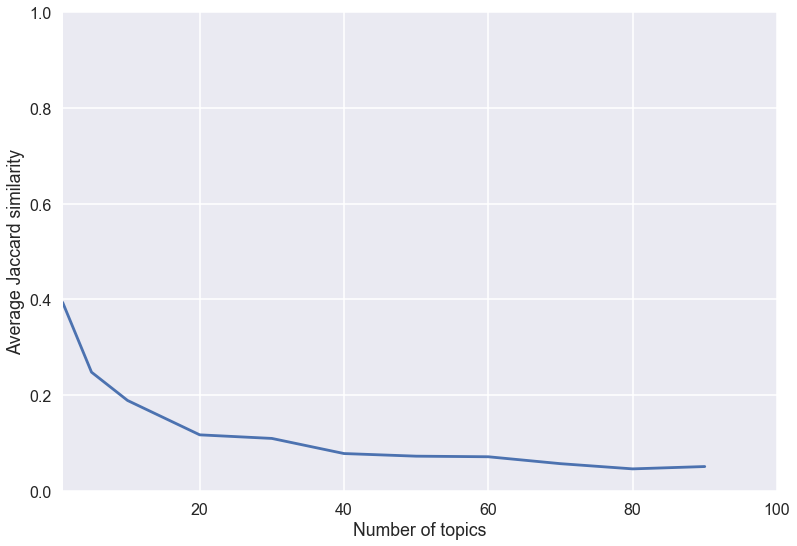

In [10]:
topicnums = [1,5,10,20,30,40,50,60,70,80,90,100]

lda_stability = pickle.load(open('pub_lda_stability.pkl','rb'))
mean_stability = [np.array(lda_stability[i]).mean() for i in topicnums[:-1]]

with sns.axes_style("darkgrid"):
    x = topicnums[:-1]
    y = mean_stability
    plt.plot(x,y,label='Mean overlap')
    plt.xlim([1, 100])
    plt.ylim([0, 1])
    plt.xlabel('Number of topics')
    plt.ylabel('Average Jaccard similarity')    
    #plt.legend()    
    plt.show()

In [11]:
num_topics = 20
lda_model = models.ldamodel.LdaModel.load('ldamodels_bow_'+str(num_topics)+'.lda')

In [12]:
lda_topics = lda_model.show_topics(num_topics)
lda_topics_words = ["".join([c if c.isalpha() else " " for c in topic[1]]).split() for topic in lda_topics]
lda_topics_disp = [("topic "+str(i)+": ")+" ".join(topic) for i,topic in enumerate(lda_topics_words)]
lda_topics_disp

[u'topic 0: main continue advertisement time trump new president day brief also',
 u'topic 1: time new get work season want first take people come',
 u'topic 2: may use people tell police report post trump time take',
 u'topic 3: people police may get think child time take see know',
 u'topic 4: time free episode clean itunes new visit guest information trump',
 u'topic 5: continue main advertisement new please time sign york state subscribe',
 u'topic 6: percent state bank trump budget new program cut change country',
 u'topic 7: bloomberg company market business data new financial percent continue time',
 u'topic 8: may rep game please know believe turkish state error protester',
 u'topic 9: trump president comey investigation fire director house white fbi russia',
 u'topic 10: trump president white golf house people washington state first new',
 u'topic 11: trump president people american continue main state time government work',
 u'topic 12: trump state president unite ice climate

In [16]:
for article in db.articles.find():
    doc = article["clean_text"]
    doc_dict = gensim.corpora.Dictionary([doc])
    doc_corp = doc_dict.doc2bow(doc)
    doc_prob = lda_model[doc_corp]
    
    for probs in doc_prob:
        db.articles.update_one({"_id": article["_id"]}, {"$set": {"topic "+str(probs[0]): probs[1]}})